In [202]:
import sys
sys.path.append('../../../notebooks')
import random
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import uci_dataset as database

from raimitigations.utils import (
    split_data,
    fetch_cohort_results,
    train_model_plot_results
)
import raimitigations.dataprocessing as dp
from raimitigations.cohort import CohortDefinition, CohortManager
from download import download_datasets

SEED = 42
#SEED = None

np.random.seed(SEED)
random.seed(SEED)

data_dir = '../../../datasets/'
download_datasets(data_dir)
df =  pd.read_csv(data_dir + 'hr_promotion/train.csv')
df.drop(columns=['employee_id'], inplace=True)
label_col = 'is_promoted'
df

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,0,45,0


In [203]:
df.isna().any()

department              False
region                  False
education                True
gender                  False
recruitment_channel     False
no_of_trainings         False
age                     False
previous_year_rating     True
length_of_service       False
KPIs_met >80%           False
awards_won?             False
avg_training_score      False
is_promoted             False
dtype: bool

In [204]:
X_train, X_test, y_train, y_test = split_data(df, label_col, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(38365, 12)
(16443, 12)


In [205]:
def get_model():
    model = LGBMClassifier(random_state=SEED)
    #model = LogisticRegression()
    return model

In [206]:
pipe = Pipeline([
    ("imputer", dp.BasicImputer(verbose=False)),
    ("scaler", dp.DataStandardScaler(verbose=False)),
    ("endcoder", dp.EncoderOHE(verbose=False)),
    ("estimator", get_model())
])
pipe.fit(X_train, y_train)
pred = pipe.predict_proba(X_test)

In [207]:
fetch_cohort_results(X_test, y_test, pred, cohort_col=["department"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16443,0.906538,0.616454,0.823112,0.615452,0.753391
1,cohort_0,"(`department` == ""Analytics"")",1646,0.776998,0.578525,0.722444,0.520467,0.620292
2,cohort_1,"(`department` == ""Finance"")",762,0.928949,0.648721,0.856663,0.673398,0.812336
3,cohort_2,"(`department` == ""HR"")",744,0.915106,0.584000,0.851852,0.556879,0.720430
4,cohort_3,"(`department` == ""Legal"")",326,0.900643,0.575758,0.864952,0.553512,0.742331
5,cohort_4,"(`department` == ""Operations"")",3366,0.904996,0.618573,0.813711,0.614847,0.743316
6,cohort_5,"(`department` == ""Procurement"")",2180,0.906561,0.631548,0.837096,0.631717,0.751835
7,cohort_6,"(`department` == ""R&D"")",324,0.813484,0.550874,0.751133,0.511048,0.706790
8,cohort_7,"(`department` == ""Sales & Marketing"")",5027,0.941234,0.625089,0.881531,0.638384,0.794311
9,cohort_8,"(`department` == ""Technology"")",2068,0.888814,0.626106,0.798857,0.612364,0.713250


In [208]:
fetch_cohort_results(X_test, y_test, pred, cohort_col=["education"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16443,0.906538,0.616454,0.823112,0.615452,0.753391
1,cohort_0,"(`education` == ""Bachelor's"")",10909,0.901324,0.599656,0.815149,0.568436,0.692456
2,cohort_1,"(`education` == ""Below Secondary"")",244,0.880221,0.633316,0.823710,0.649573,0.790984
3,cohort_2,"(`education` == ""Master's & above"")",4539,0.911406,0.631539,0.833324,0.627961,0.742454
4,cohort_3,(`education`.isnull()),751,0.947114,0.615054,0.885469,0.637268,0.826897


In [209]:
fetch_cohort_results(X_test, y_test, pred, cohort_col=["gender"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16443,0.906538,0.616454,0.823112,0.615452,0.753391
1,cohort_0,"(`gender` == ""f"")",4770,0.901428,0.622138,0.818894,0.615670,0.736268
2,cohort_1,"(`gender` == ""m"")",11673,0.908411,0.613932,0.824385,0.615038,0.760644


In [210]:
fetch_cohort_results(X_test, y_test, pred, cohort_col=["recruitment_channel"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16443,0.906538,0.616454,0.823112,0.615452,0.753391
1,cohort_0,"(`recruitment_channel` == ""other"")",9127,0.904970,0.615133,0.818465,0.615180,0.755889
2,cohort_1,"(`recruitment_channel` == ""referred"")",316,0.877682,0.631111,0.787951,0.637350,0.756329
3,cohort_2,"(`recruitment_channel` == ""sourcing"")",7000,0.910529,0.621039,0.834244,0.623219,0.761000


In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_value_counts_cohort(y_full, subsets, normalize = True):
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    sns.set_theme(style="whitegrid")
    if normalize:
        plt.ylim(0, 1)
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=23)

    value_count = y_full.value_counts(normalize=normalize)

    subsets_col = ['full df', 'full df']
    counts_col = [value_count[0], value_count[1]]
    label_col = [0, 1]

    for key in subsets.keys():
        value_count = subsets[key]["y"].value_counts(normalize=normalize)
        subsets_col += [key, key]
        counts_col += [value_count[0], value_count[1]]
        label_col += [0, 1]

    count_df = pd.DataFrame({"subsets":subsets_col, "label":label_col, "counts":counts_col})
    
    y_label = "Occurrences"
    if normalize:
        y_label = "Fraction"

    ax = sns.barplot(x="subsets", y="counts", hue="label", data=count_df)
    ax.set_xlabel("Subsets", fontsize=30)
    ax.set_ylabel(y_label, fontsize=30)
    #ax.tick_params(labelsize=15)
    plt.show()

# department

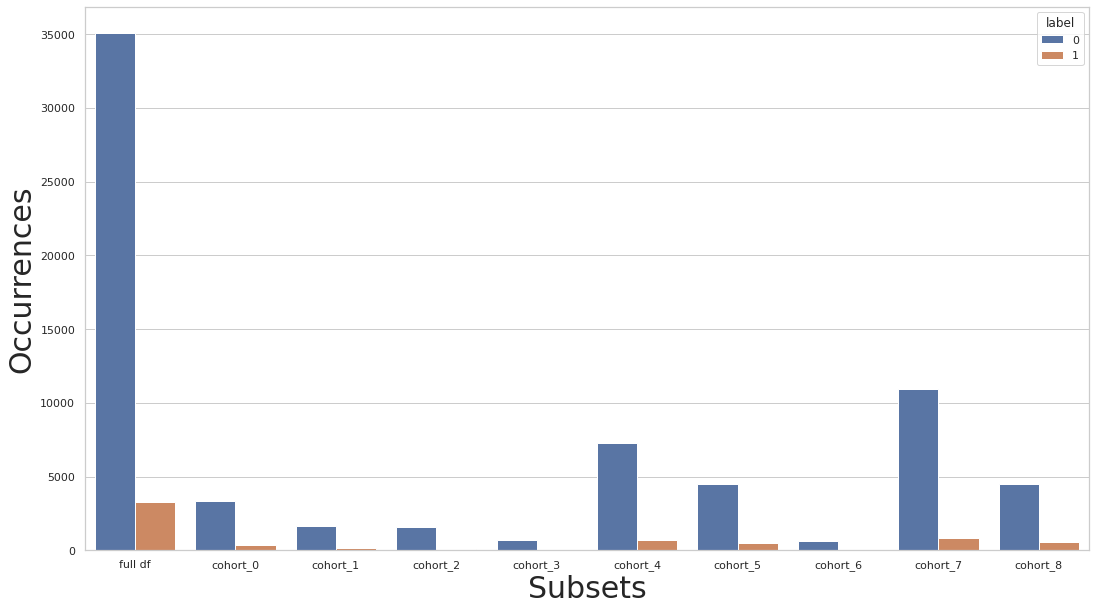

In [212]:
cohort_set = CohortManager(
    cohort_col=["department"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets = cohort_set.get_subsets(X_train, y_train, apply_transform=False)

#print(y_train.value_counts())
#for key in subsets.keys():
#    print(f"\n{key}:\n{subsets[key]['y'].value_counts()}\n***********")

plot_value_counts_cohort(y_train, subsets, normalize=False)

In [222]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_col=["department"]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["department"])

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-toolbox-mitigations-private/raimitigations/utils/model_utils.py:140: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16443,0.896297,0.608318,0.811462,0.597154,0.730889
1,cohort_0,"(`department` == ""Analytics"")",1646,0.739505,0.569908,0.689931,0.533177,0.657959
2,cohort_1,"(`department` == ""Finance"")",762,0.914678,0.667155,0.821153,0.704124,0.858268
3,cohort_2,"(`department` == ""HR"")",744,0.896995,0.582149,0.822039,0.568160,0.748656
4,cohort_3,"(`department` == ""Legal"")",326,0.918971,0.627995,0.846945,0.669595,0.889571
5,cohort_4,"(`department` == ""Operations"")",3366,0.895444,0.605694,0.801792,0.575266,0.687463
6,cohort_5,"(`department` == ""Procurement"")",2180,0.902884,0.622536,0.833767,0.602760,0.711009
7,cohort_6,"(`department` == ""R&D"")",324,0.688026,0.529920,0.667961,0.385691,0.487654
8,cohort_7,"(`department` == ""Sales & Marketing"")",5027,0.937158,0.625365,0.881852,0.638935,0.794907
9,cohort_8,"(`department` == ""Technology"")",2068,0.874313,0.638954,0.782902,0.655217,0.782398


In [223]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
    ],
    cohort_col=["department"]
)

pipe = Pipeline([
    ("imputer", dp.BasicImputer(verbose=False)),
    ("cht_manager", cht_manager),
    ("endcoder", dp.EncoderOHE(verbose=False)),
    ("estimator", get_model())
])
pipe.fit(X_train, y_train)
pred_cht = pipe.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["department"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16443,0.906902,0.612515,0.820641,0.604821,0.738795
1,cohort_0,"(`department` == ""Analytics"")",1646,0.773179,0.580026,0.719360,0.542708,0.660389
2,cohort_1,"(`department` == ""Finance"")",762,0.931687,0.637606,0.850456,0.652572,0.788714
3,cohort_2,"(`department` == ""HR"")",744,0.912868,0.578947,0.840456,0.541448,0.698925
4,cohort_3,"(`department` == ""Legal"")",326,0.907610,0.577320,0.868167,0.558003,0.748466
5,cohort_4,"(`department` == ""Operations"")",3366,0.903637,0.612675,0.809481,0.598025,0.719846
6,cohort_5,"(`department` == ""Procurement"")",2180,0.912392,0.634961,0.838907,0.640132,0.762844
7,cohort_6,"(`department` == ""R&D"")",324,0.839698,0.568778,0.810356,0.553309,0.759259
8,cohort_7,"(`department` == ""Sales & Marketing"")",5027,0.941527,0.625549,0.882066,0.639303,0.795305
9,cohort_8,"(`department` == ""Technology"")",2068,0.880740,0.622859,0.796900,0.600703,0.696325
